### 경제 데이터 확인
일반적으로 알려진 경제, 금융 관련 데이터를 보고 projection을 알고자 한다. 이 노트북에서는 경제 거시지표와 금융상품의 티커 또는 내부 ID를 그대로 사용하며 기본적인 경제 과정에 대해서 말하지 않는다.

#### 데이터 로드
da.py에는 FRED와 Yahoo Finance의 데이터를 부분 획득, 업데이트하는 getdata 메서드가 있다.
* 초회 실행 시 기정의 경로에 f.csv가 있어야 한다.
* CME 선물 가격과 같이 오래된 라이센스드 데이터는 직접 구해야 한다.
* FRED와 Yahoo Finance에서 자기가 원하는 series를 티커 또는 ID로 추가할 수 있다.

In [1]:
from da import *
data=getdata(-1,save=True)
data.info()

[*********************100%***********************]  16 of 16 completed
            us02y         uj          ks          sp
date                                                
2023-07-19   4.74  139.02699  2608.23999  4565.72021
2023-07-20   4.80  139.59801  2600.22998  4534.87012
2023-07-21    NaN  141.77000  2609.76001  4536.33984
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15908 entries, 1980-01-01 to 2023-07-21
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   adp     162 non-null    float64
 1   ahe     208 non-null    float64
 2   cb      6931 non-null   float64
 3   cci     522 non-null    float64
 4   ci      522 non-null    float64
 5   cl      5751 non-null   float64
 6   djia    2518 non-null   float64
 7   fert    511 non-null    float64
 8   fr      15907 non-null  float64
 9   fs      1542 non-null   float64
 10  gdp     173 non-null    float64
 11  hg      5746 non-null   float64
 12  hi      436 non

#### 상관성 확인
da.py에는 상관계수 heatmap을 그리는 wrapper 메서드 hm이 있다.

상관계수 확인은 자주 사용되지만 유의점이 있다.
* 인과관계가 아니다.
* 관계가 선형이 아니면 상관 정도가 과소평가된다.
* 상품 가격은 daily closing price이므로 상관 정도가 대체로 과소평가된다.

sp, ks, hs, us02y, fr, si의 상관성을 확인한다.

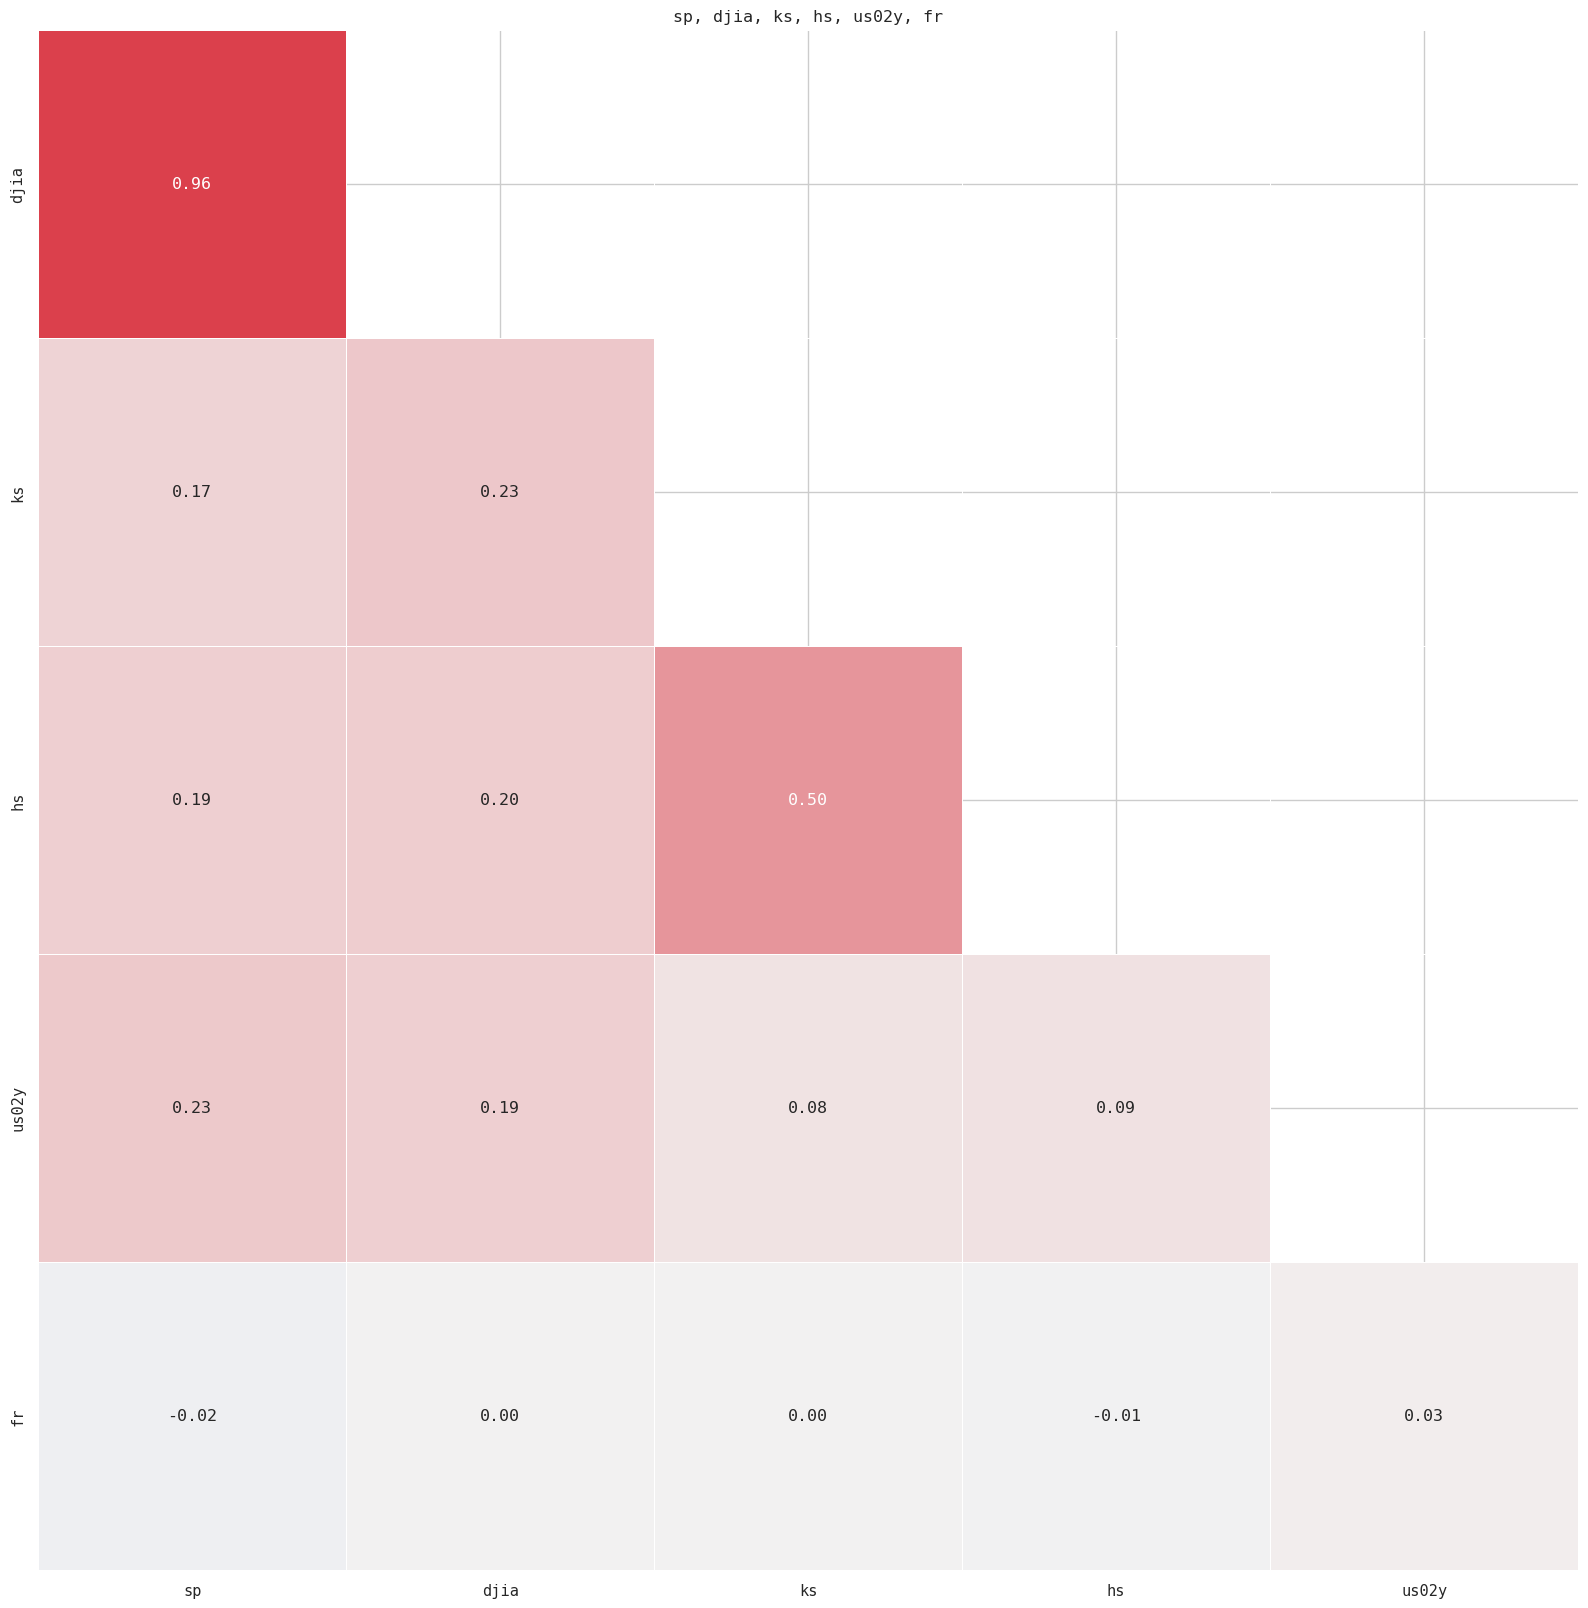

In [2]:
targets=["sp","djia","ks","hs","us02y","fr"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna(subset=["sp","ks","hs"]).pct_change()[1:]
hm(_data.corr())


* us02y와 주가지수 변화율이 동행한다.
    * 미래 GDP 증가가 국채 일드를 담보한다.
    * 금리 인상은 주가지수가 높으므로 가능하다.
    * 구조적 문제가 발생할 때 국채 일드와 주가지수는 같이 하락한다.
* fr와 us02y의 상관계수가 크지 않다.
    * fr(SOFR)이 고시성 가격이기 때문이다.
    * 타임프레임을 크게 하면 상관계수가 커질 것이다.
* sp와 hs, ks의 상관계수가 크지 않다.
    * Overlapping session이 아니기 때문이다. sp는 연결선물 가격이 아니다.
* 타임프레임이 커질수록 상관 정도는 뚜렷해질 것이다.

#### 래깅 상관계수
야간장 주가지수 변화율이 내일 주간장(아시아 세션)에 영향을 준다고 생각한다. 위 heatmap에서는 관계가 뚜렷하지 않다.

sp와 ks는 session time이 다르므로 daily delta 상관계수가 낮올 수 있다. sp와 ks를 예로 들어 t일 야간장이 t+1일 주간장와 상관이 있는지 본다.

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]),
 array([-0.00261085,  0.01330577,  0.02611343,  0.09921784,  0.29949893,
         0.16312943,  0.01571489, -0.0050963 , -0.01923606, -0.01220708,
        -0.00243977]),
 <matplotlib.lines.Line2D at 0x1baeebc8410>)

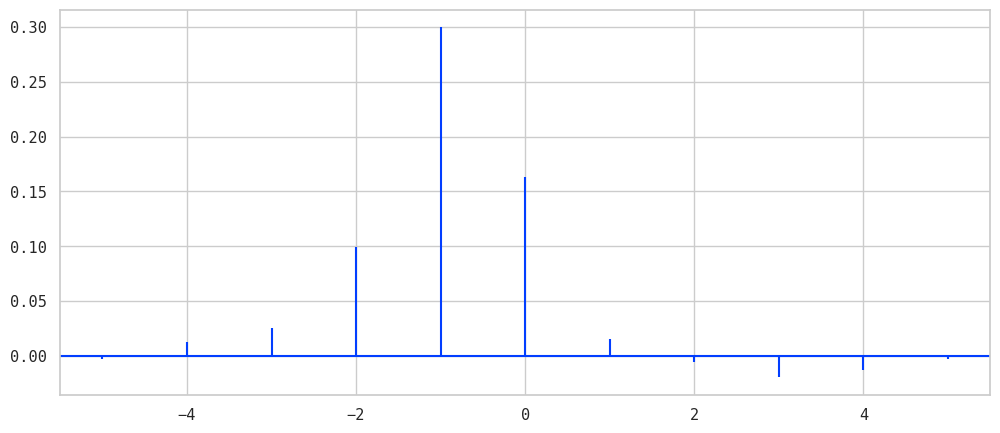

In [3]:
targets=["sp","ks"]
_data=data[targets].interpolate(limit_area="inside",limit=1).dropna().pct_change()[1:]
plt.xcorr(_data.sp,_data.ks,maxlags=5)

* ks를 -1일 shift하면 sp와 0.3의 상관계수를 갖는다.
* dji, ndx도 ks (-1)에 대해 0.3 내외의 상관계수를 갖는다.

Session time에 따라 daily delta의 상관성이 달라지며 전일 야간장 변화율이 명일 주간장 변화율에 상관됨을 알았다. 래깅에 따라 상관계수 변화가 있다고 해도 인과관계 유무로 해석할 수 없다.

#### 고용지표
고용지표는 대부분 1개월 이상 후행적이어도 국채 일드/주가지수 추이를 결정하는 중요한 요인이다.
* 주가지수 변화율이 수개월내 도래 고용지표 변화율과 상관관계가 있다.
* GDP는 NFP의 결과이다. 두 지표의 변화율 plot의 면적이 거의 일치한다.
* 고용지표 변화율과 inflating 정도에 양의 상관관계가 있다.

고용지표에는 3가지가 있다.
* unrate: 실업률. 잘 변하지 않지만 대표성이 높다.
* nfp: Nonfarm Payrolls. 월간 새로 생성된 일자리 개수이다.
* icsa: Inicial Claims. 주간 실업수당 청구건수이다. 1주일밖에 후행적이지 않다.

먼저 고용지표 변화율을 그려 본다.

<Axes: xlabel='date'>

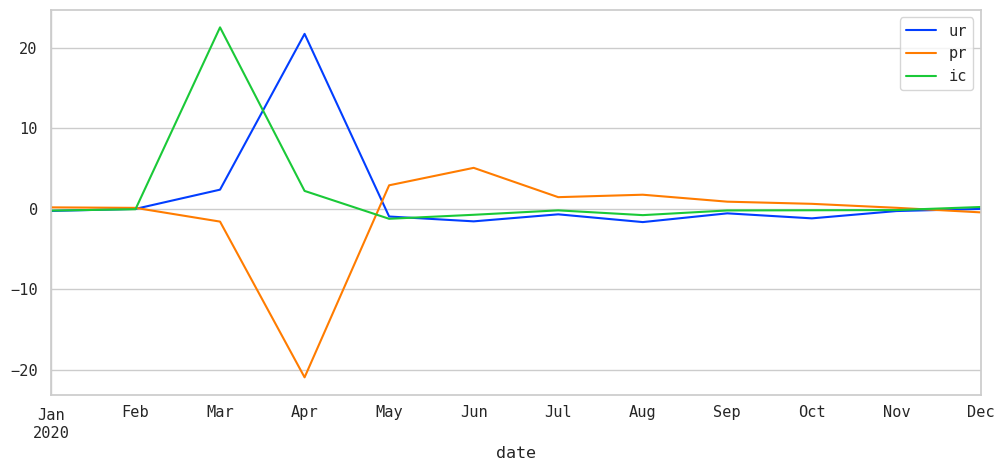

In [4]:
targets=["ur","pr","ic"]
_data=data[targets].resample("m").mean().pct_change()[1:]
_data=scipy.stats.zscore(_data,nan_policy="omit")
_data.loc["2020"].plot()

* ICSA가 상승하면 NFP가 감소하고 UNRATE가 증가한다.
* 일자리 거시지표 변화의 발생 순서가 항상 있지 않다.
    * 2020년은 타격된 업종이 layoff가 빠른 서비스업이기 떄문일 것이다.

ICSA, NFP, UNRATE의 특성을 알았다. 이제 NFP와 주가지수의 관계를 본다.

<Axes: xlabel='date'>

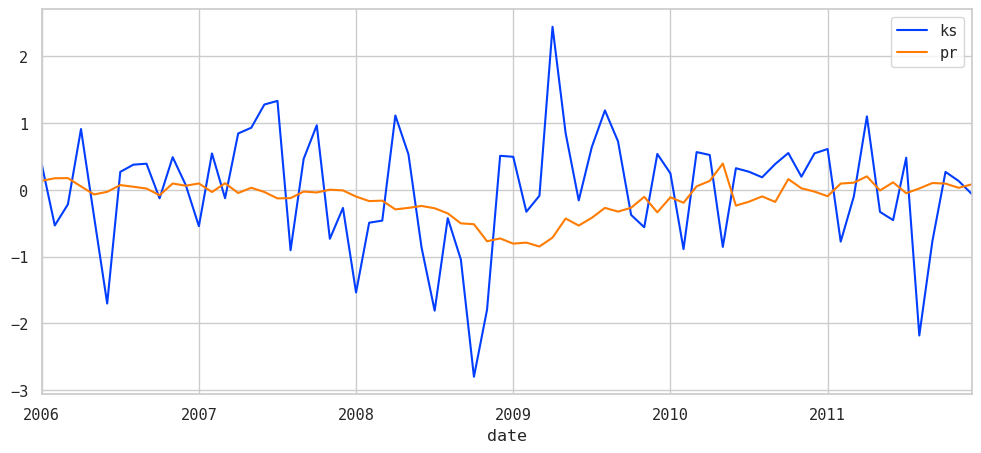

In [5]:
targets=["ks","pr"]
_data=data[targets].resample("m").mean().pct_change().dropna()
_data=scipy.stats.zscore(_data)
_data.loc["2006":"2011"].plot()

* 주가지수는 당월 발표된 전월 NFP의 정도를 이전에 이미 반영한다.
* 주가지수/NFP 변화율에는 약한 음의 상관관계가 있다.

<Axes: xlabel='date'>

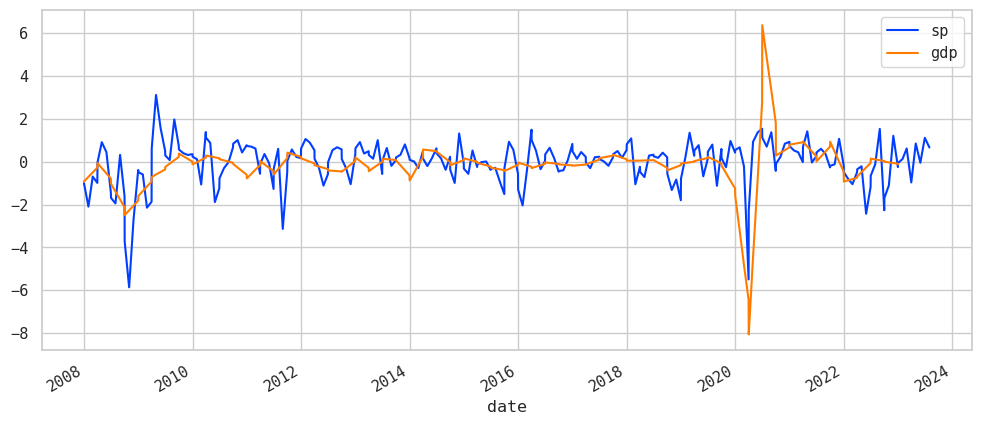

In [6]:
sp=data.sp.resample("m").mean().pct_change(fill_method=None)
gdp=data.gdp.dropna().pct_change(fill_method=None)
sp_to_gdp=scipy.stats.zscore(pd.concat([sp,gdp],axis=1).dropna(how="all"),nan_policy="omit").interpolate(limit_area="inside")
sp_to_gdp.loc["2008":].plot()

* NFP 델타가 GDP 델타에 선행하므로 주가지수도 GDP에 선행한다.
* GDP는 4개월 후행적이므로 당행 주가지수는 4개월 이내 도래 고용지표, 가격지표에 영향한다.
    * 전월 가격지표가 하회하면 당월 및 도래 최근월 가격지표가 상승하도록 주가는 상승한다. 반대의 경우 주가는 하락한다.
    * 명목 가격으로서 주가지수는 상승하지만 그 과정에서 변화율은 동적으로 평형을 이루려 한다.

#### 가격지표
가격지표는 1개월 이상 후행적이어도 국채 일드/주가지수 추이를 결정하는 요인이다. 유동성 주입, 가격 상승, 일자리 증가, 주가지수 상승이 같은 맥락에 있음을 안다면 가격지표의 중요성을 알 수 있다.

* 가격지표는 미래 inflating 정도를 조절한다: 그 정도에 따라 국채 일드을 포함, 명목 가격을 inflating 또는 deflating 시킨다.
* CPI, PCE와 volatility가 높은 원자재 부문을 뺀 core가 있다.
* 흔히 말하는 2% inflation target이란 Core PCE MoM 2%이다.
    * PCE가 중요하지만 CPI 이후 공개되어 CPI 기반 예측이 쉽다.
* PPI도 CPI 이후 공개되어 중요하지 않다.

가격지표 및 그와 상관관계가 있을 것 같은 몇 가지 지표를 그린다.

<Axes: xlabel='date'>

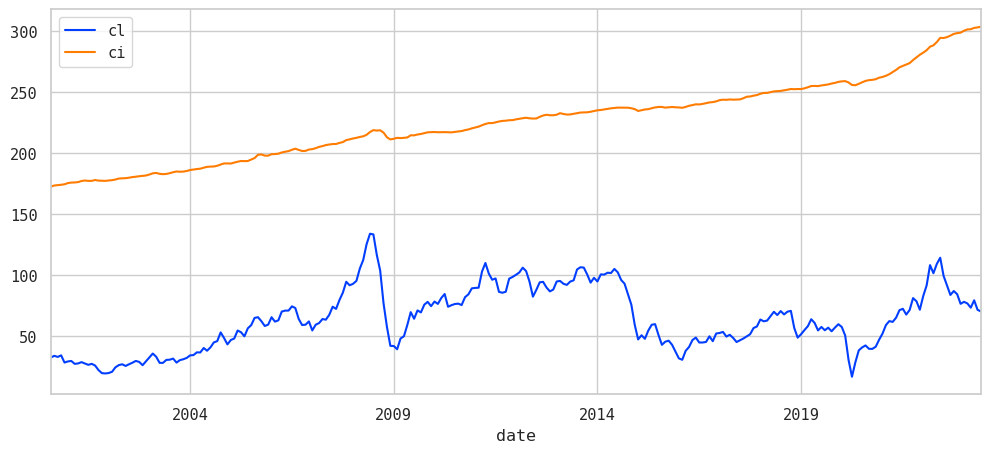

In [7]:
data[["cl","ci"]].resample("m").mean().dropna().plot()

* 특별한 처리 없이 그려도 유가와 가격지표의 상관관계가 나온다.
* 원유/천연가스 선물 가격만 집적해도 헤드라인 CPI는 예측이 쉽다.

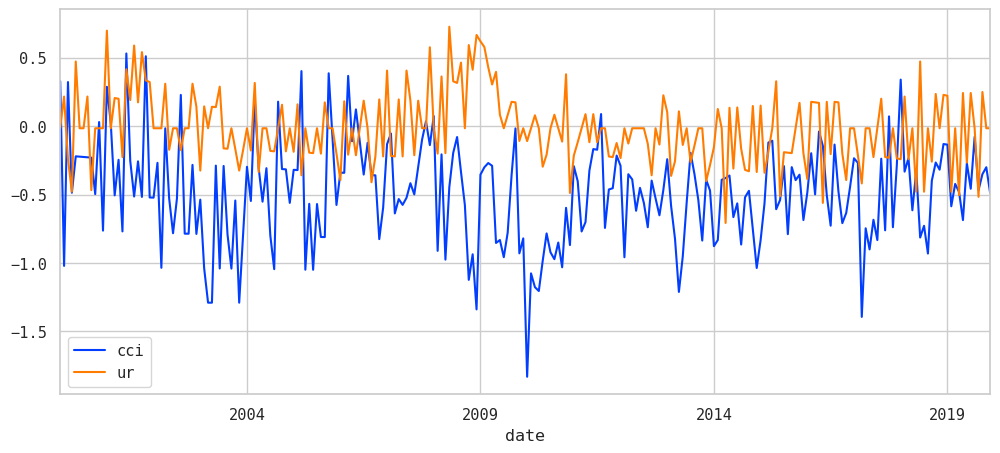

(array([-3, -2, -1,  0,  1,  2,  3]),
 array([ 0.01757248,  0.04026014, -0.03636296, -0.15187164, -0.08281003,
        -0.03715991,  0.04006506]),
 <matplotlib.lines.Line2D at 0x1baeeccab50>)

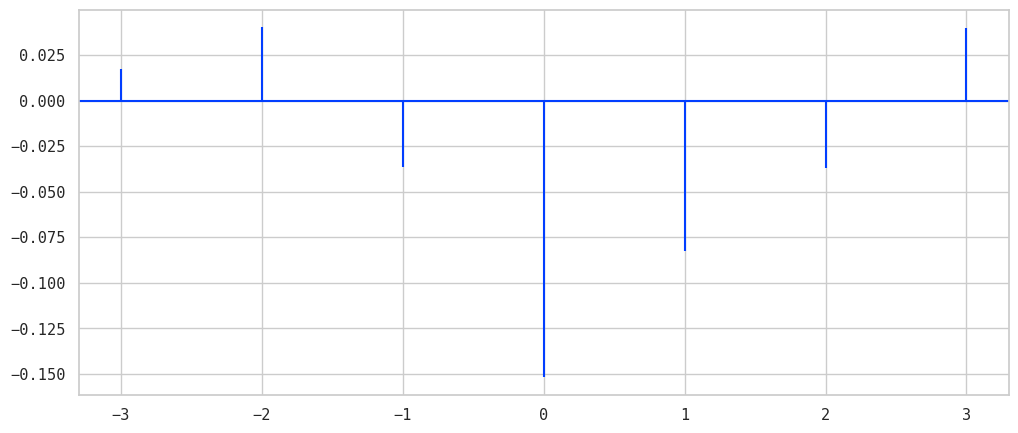

In [8]:
_data=scipy.stats.zscore(data[["cci","ur"]].resample("M").mean().pct_change(fill_method=None).dropna(how="all"),nan_policy="omit")
_data.loc["2000":"2019"].plot(),plt.show()
plt.xcorr(_data.cci,_data.ur,maxlags=3)

* cci와 ur에는 전기간에 걸쳐 약한 음의 상관관계가 있고 정도는 context에 따라 다름
    * t-1 실업률 변화율이 t 근원 CPI 변화율에 음의 영향
    * 맥락에 따라 상관 정도가 커진다: 2022년 이후 0.3~

#### 비정상성, 랜덤워크
데이터의 대부분은 정상성이 없다. 나스닥 일일 종가는 정상성이 없다. t일의 종가는 t-1일의 종가의 어느 정도에 머무른다. 나스닥 일일 종가와 코스피 일일 종가의 상관계수는 1에 가깝다. 시간의 흐름에 따라 유동성이 주입되므로 모든 상품의 명목 가격은 동시 상승한다. 이는 '사람들이 나이를 먹어가면 주가지수가 상승한다'와 같은 맥락에서 아무런 의미가 없는 사실이다.

정상성 여부는 ADF나 자기상관계수를 구하거나 그려봐도 대충 알 수 있다.

<Axes: xlabel='date'>

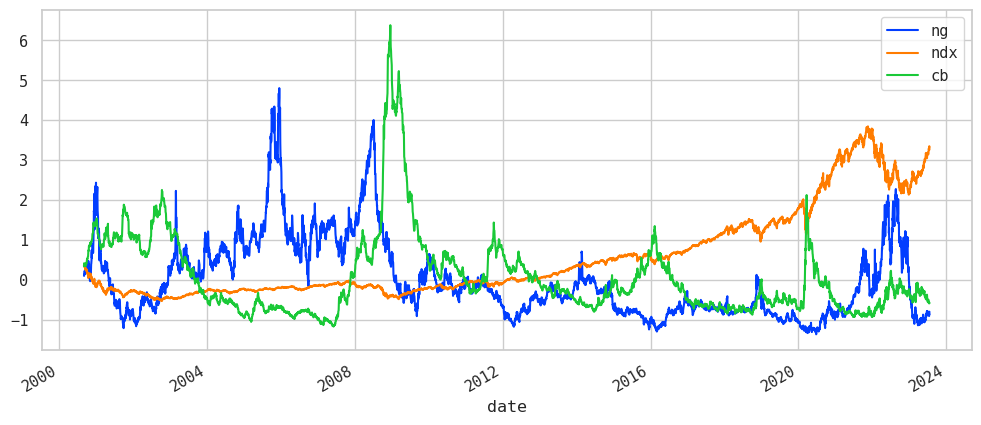

In [9]:
scipy.stats.zscore(data[["ng","ndx","cb"]],nan_policy="omit").dropna().plot()

* ng는 천연가스 연결선물(spot) 가격이다. 변동성이 크고 전체 기간 평균에 대한 회귀 경향이 있어 정상성이 있어 보인다.
* ndx는 나스닥 일일 종가이다. 정상성이 없다.
* cb는 회사채 일드 스프레드이다. ng보다도 정상성이 있어 보인다.

비정상적 데이터는 전체 기간의 평균이 의미가 없다. ng는 전체 기간의 평균이 의미가 있다(사실 구간에 따라 다르지만 다른 명목 가격에 비해서는 정상성이 매우 높다). 이런 경우는 드물다. si는 전체 기간을 두고 ADF를 통과하지만 미시적으로는 정상성이 없다. 널리 알려진 것과 다르게 si와 gc의 공적분은 유의하지 않다.

<Axes: xlabel='date'>

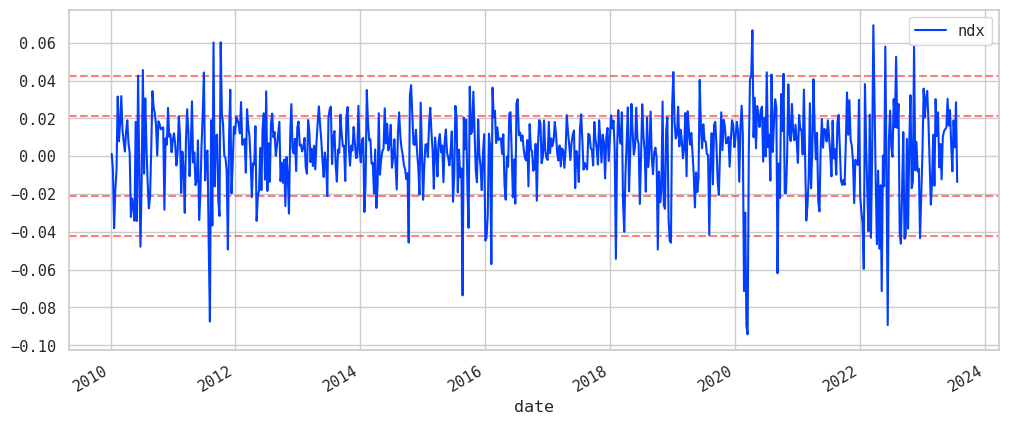

In [10]:
_data=data[["ndx"]].loc["2010":].resample("7d").mean().pct_change().dropna()
fg,ax=plt.subplots()
[ax.axhline(y=_data.ndx.std()*q,linestyle="dashed",alpha=.5,color="red") for q in (-2,-1,1,2)]
_data.plot(ax=ax)

* ndx 등 상품 가격은 랜덤워크이다.
    * 빨간 선은 daily delta의 2010년 이후 기준 1, 2 시그마이다.
* 변화율이 큰 부분에서 price action이 발생했다.
    * 이처럼 도래 지점까지 nominal price의 변동성 정도나 slope 특성을 규정하는 '맥락 인자'가 있다.

비정상적이고 랜덤워크를 따르는 가격을 두고 기술적으로 레벨을 알려는 것은 스타벅스를 방문하는 남자의 키가 길어졌다가 짧아질 것으로 다음 남자의 키를 알려는 것과 같다. HFT에서 delta / nominal price의 std를 활용하는 true range가 생각보다 선방하지만 지속될 수 없다. LSTM와 같은 기계학습의 근간이 수십년 전 태동했다는 점을 생각하면, 시장 미시적 행위에서 기술적 분석은 의미가 없다.

#### 소매
당월의 전월 t rs가 t 전후 djia 변화율에 어떻게 영향하는가? 

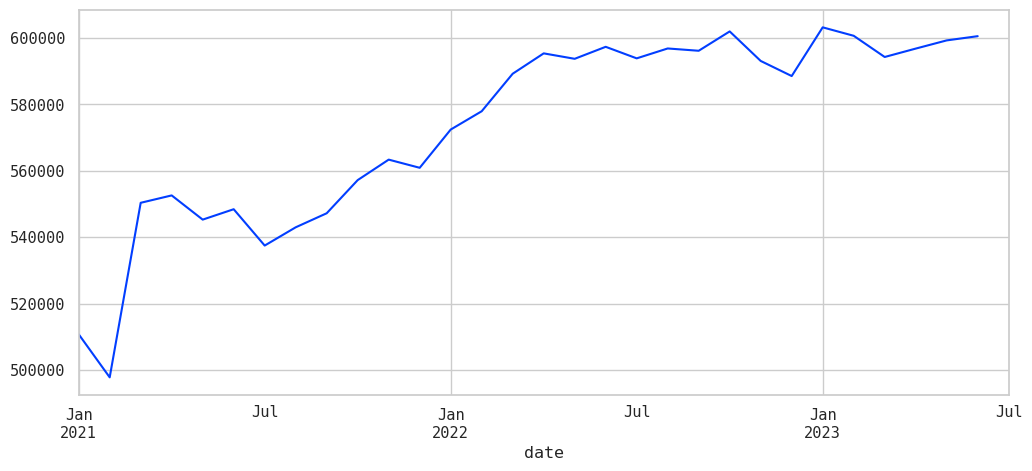

xcorr (-1, 0.36420746030520584)


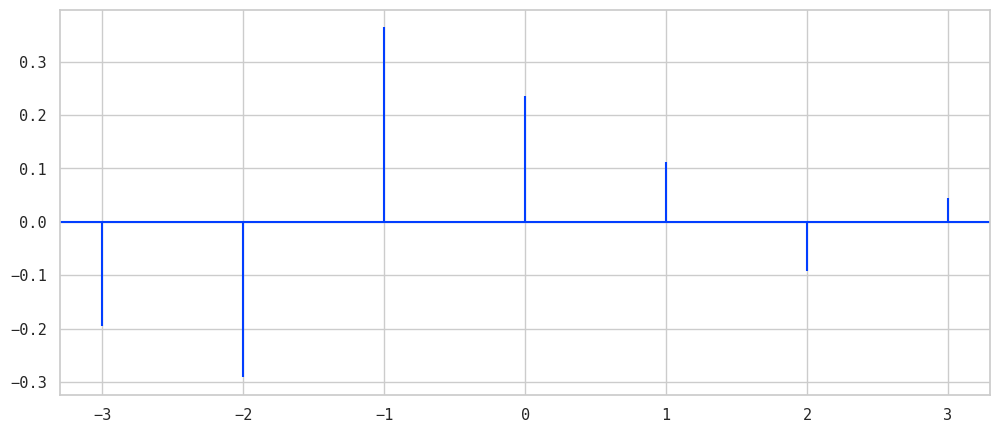

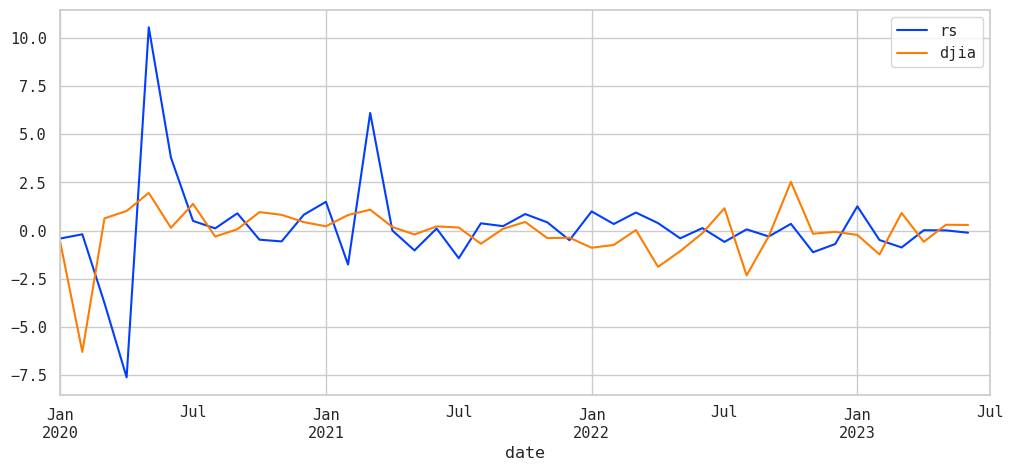

(<Axes: xlabel='date'>, None)

In [11]:
data.rs.resample("m").mean().loc["2021":].plot(),plt.show()
rs=data.rs.resample("m").mean().pct_change(fill_method=None).dropna()
djia=data.djia.resample("m").mean().pct_change()
lattice=scipy.stats.zscore(pd.concat([rs,djia],axis=1),nan_policy="omit").dropna(subset=["djia"])

djia_to_rs=plt.xcorr(lattice.dropna().djia,lattice.dropna().rs,maxlags=3)
djia_to_rs_idx=abs(djia_to_rs[1]).argmax()
print("xcorr",(djia_to_rs[0][djia_to_rs_idx],djia_to_rs[1][djia_to_rs_idx]))

lattice_=lattice.loc["2020":]
lattice_.djia=lattice_.djia.shift(-1)
lattice_.plot(),plt.show()

* 7월 발표되는 전월 rs의 컨센서스는 불명: djia 변화율 z-score 변화율이 크지 않음
    * djia 변화율 z-score 낼 때 엄밀한 근거 필요

#### ICSA와 CB
회사채 일드 스프레드는 회사채 일드와 국채 일드의 차이를 나타낸다. 즉, 회사채 일드 스프레드는 당시 국채에 대한 회사채의 위험도를 보이며, 회사의 미래 매출과 배당에 대한 할인율이 된다. 이 지표는 1일 후행적이면서 대표성이 매우 높다. [모든 Recession Indicator에서 회사채 일드 스프레드를 사용하며, 이것 하나만으로도 Recession Indicator가 된다.](https://research.stlouisfed.org/publications/economic-synopses/2010/01/15/measuring-financial-market-stress/) 

아래 플랏은 회사채 일드 스프레드가 상승할 때 주간 실자리 청구건수가 증가함을 보인다.

<Axes: xlabel='date'>

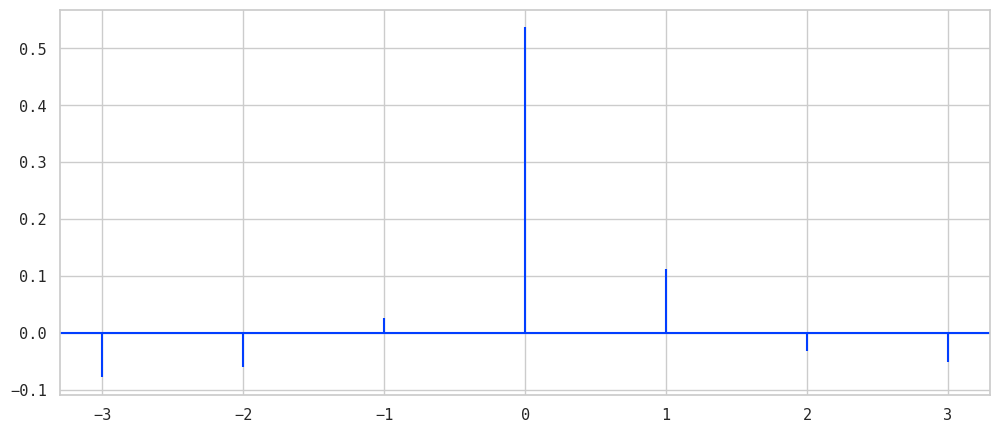

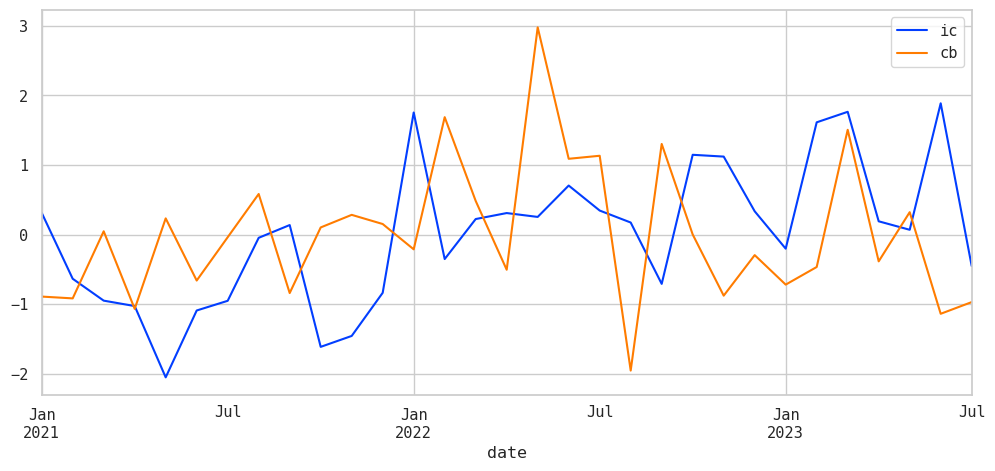

In [12]:
exam=data[["ic","cb"]].resample("m").mean().pct_change(fill_method=None)
exam_=exam.dropna()
plt.xcorr(exam_.ic,exam_.cb,maxlags=3)
scipy.stats.zscore(exam.loc["2021":],nan_policy="omit").plot()

#### NFP의 예측
##### 왜 NFP인가
t에 발표되는 t-1의 NFP 델타가 t 이후 명목 가격을 결정하는 것을 확인했다. 시장참가자의 관점에서 NFP는 일상적 맥락에서 명목 가격의 추이를 결정하는 가장 중요한 지표이다.

##### 왜 XGBoost인가
쓰기 쉽고 플랫폼에서 CUDA를 지원하기 때문이다. 정확도의 측면에서 어떤 모델을 쓰는지는 중요하지 않다. [클리블랜드 연준의 CPI Nowcasting은 중회귀인데 컨센서스나 타 모델보다 정확도가 수십 pct 높다.](https://doi.org/10.26509/frbc-wp-201403r)

##### 진행 수순

In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xy=data[["cb","ic","pr"]].resample("m").mean().dropna(subset=["cb"])
xy.pr=xy.pr.diff()
xy=xy.iloc[1:]
xy.agg(["mean","median","std"])

,cb,ic,pr
mean,5.39400,378189.18495,110.24843
median,4.71143,325250.00000,182.50000
std,2.56385,317674.73076,1226.47840


In [14]:
yj={serie:scipy.stats.yeojohnson(xy[serie]) for serie in xy.columns}
xy_yj_lambda={serie:yj[serie][1] for serie in yj}
xy_yj=pd.DataFrame({q[0]:q[1][0] for q in yj.items()})
xy_yj.agg(["mean","median","std"])

,cb,ic,pr
mean,0.82923,9.11408e-01,3.78265e+27
median,0.82847,9.11408e-01,1.77804e+18
std,0.05154,2.60970e-07,6.68166e+28


In [15]:
xy_yj_zs=scipy.stats.zscore(xy_yj,nan_policy="omit")
x=xy_yj_zs.iloc[:-1,:2]
y=xy_yj_zs.iloc[:-1, 2]

In [16]:
params={
    "max_depth":[q for q in range(2,13,2)],
    "gamma":[q for q in range(0,3,1)],
    "alpha":[q for q in range(0,3,1)],
    "lambda":[q for q in range(0,6,1)],
    "n_estimators":[100,200],
}
estimator=XGBRegressor(tree_method="gpu_hist")
cv=GridSearchCV(estimator,params,verbose=1)
cv.fit(x,y)
score=pd.DataFrame(cv.cv_results_).sort_values(by=["mean_test_score","std_test_score"],ascending=False)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [17]:
list(map(print,score[:10].params))

{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 2, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 4, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 6, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 8, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 10, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 3, 'max_depth': 12, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 0, 'max_depth': 2, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 0, 'max_depth': 2, 'n_estimators': 200}
{'alpha': 0, 'gamma': 0, 'lambda': 5, 'max_depth': 2, 'n_estimators': 100}
{'alpha': 0, 'gamma': 0, 'lambda': 4, 'max_depth': 4, 'n_estimators': 100}


[None, None, None, None, None, None, None, None, None, None]

In [18]:
x_=xy_yj_zs.iloc[-1,:2].to_numpy().reshape(1,-1)
y_=cv.predict(x_)[0]

y_mean=(y_ * xy_yj_zs.pr.mean()) + xy_yj_zs.pr.mean()
y_mid =(y_ * xy_yj_zs.pr.median()) + xy_yj_zs.pr.median()

print("mean-based:",y_mean)
print("median-based:",y_mid)
print("pr lambda:",xy_yj_lambda["pr"])

def invert_yeojhonson(value, lmbda):
  if value>= 0 and lmbda == 0:
    return exp(value) - 1
  elif value >= 0 and lmbda != 0:
    return (value * lmbda + 1) ** (1 / lmbda) - 1
  elif value < 0 and lmbda != 2:
    return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
  elif value < 0 and lmbda == 2:
    return 1 - exp(-value)

print("expected NFP delta of nearest month:",invert_yeojhonson(y_mean,xy_yj_lambda["pr"]))

mean-based: 2.634651273062273e-17
median-based: -0.053486743418725106
pr lambda: 8.472135811722177
expected NFP delta of nearest month: 0.0


### 근거
[Ben S. Bernanke, Bernanke's Lecture Serie](https://www.youtube.com/watch?v=E3fFg8XIS0k), 2012.  
[Ministry of Finance, 10-year Inflation-Indexed Bonds](https://www.mof.go.jp/english/policy/jgbs/topics/bond/10year_inflation/index.htm), December 11, 2022.  
SAS를 이용한 현대통계학 2e, 최병선, 2003.  
통계학 3e, 류근관, 2016.  
Eric C. Engstrom et al., The Near-Term Forward Yield Spread as a Leading Indicator: A Less Distorted Mirror, 2018.  
H. Clark et al., How Stable Is China’s Growth? Shedding Light on Sparse Data, 2020.  
Kevin L. Kliessen, Measuring Financial Market Stress, 2010.  
Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [DFF], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Employment and Training Administration, Initial Claims [ICSA], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, All Employees, Total Nonfarm [PAYEMS], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Economic Analysis, Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) [PCEPILFE], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average [CPILFESL], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
Ice Data Indices, LLC, ICE BofA US High Yield Index Option-Adjusted Spread [BAMLH0A0HYM2], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Census Bureau, Advance Retail Sales: Retail Trade [RSXFS], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
U.S. Bureau of Economic Analysis, Real Gross Domestic Product [GDPC1], retrieved from FRED, Federal Reserve Bank of St. Louis, July 21, 2023.  
[Yahoo! API T&C](https://legal.yahoo.com/us/en/yahoo/terms/product-atos/apiforydn/index.html)  
[
ShamimaMoni / Inverse-yeo-johnson.ipynb](https://gist.github.com/ShamimaMoni/e06883bd0a6c0d94a208d3fa7ba5b18c)